# Proyecto Machine Learning

El objetivo de este poryecto es implementar un modelo de lenguaje natural que sea capaz de predecir con cierta exactitud cuándo un texto dado ha sido generado por una inteligencia artificial.

Para esto, se buscaron y recopilaron diversa cantidad de texto, los cuales han sido generados por un humano o por una inteligencia artificial a raíz de una especificación para dicho texto (Prompt).

In [1]:
# En caso de ser necesario, se descargan las librerías extra necesarias
# para realizar el modelo

!pip install keras_nlp

In [2]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras_nlp
import keras
import tensorflow as tf

In [3]:
# Función que grafica la distribución de textos generados por I.A y por humanos
def plot_text_distribution(data):
    # Inicializando la gráfica
    fig, ax = plt.subplots(figsize = (12, 4))
    sns.despine()
    ax = sns.countplot(data = data, x = 'generated')

    # Viendo los valores
    abs_values = data['generated'].value_counts()
    abs_values.rename(index = {0: 'No', 1: 'Sí'}, inplace = True)

    # Graficando la distribución
    ax.bar_label(container = ax.containers[0],
                 labels = abs_values.values)
    ax.set_xticklabels(labels = abs_values.index.values)
    ax.set_xlabel(xlabel = 'Generado')
    ax.set_ylabel(ylabel = '')
    ax.set_title('Distribucion de texto generado')

# Schedule para corregir la tasa de aprendizaje
def scheduler(epoch, lr):
    if epoch == 3:
        return lr * tf.math.exp(-0.1)
    else:
        return lr 

## Preprocesado y análisis de los datos obtenidos

In [4]:
# Importando los datos a analizar
dataframe_train = pd.read_csv('/kaggle/input/datatrain/train_essays.csv')
prompts         = pd.read_csv('/kaggle/input/datatrain/train_prompts.csv')
dataframe_test  = pd.read_csv('/kaggle/input/datatrain/test_essays.csv')

En la base que contiene los datos a entrenar se tienen las columnas de identificador, identificador del prompt, el texto y si ha sido generado o no por una inteligencia articiail. Igualmente la base de los datos de testeo.

En primera instancia se observó que en los datos de entrenamiento hay un desbalance entre los textos catalogados como generados por una inteligencia articial y los catalogados como generados por un humano.

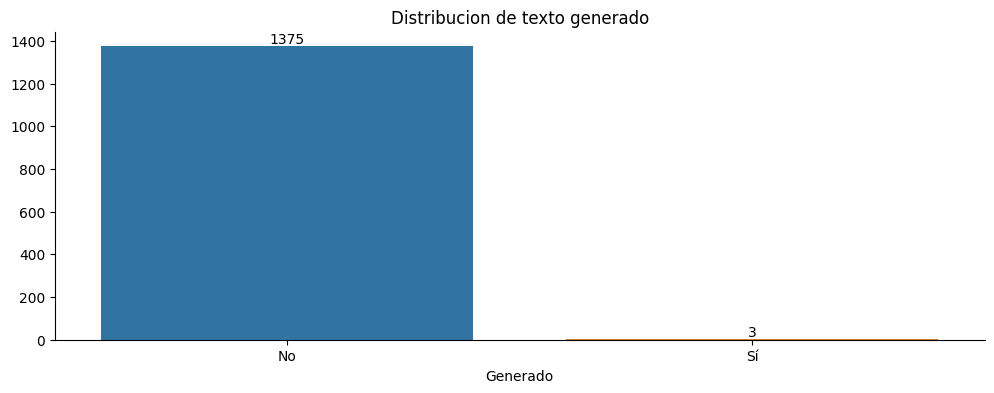

In [5]:
# Visualización de la proporción de los datos
plot_text_distribution(dataframe_train)

Como el error que se evidenció es que hay una insuficiencia de datos catalogados como generados por una inteligencia artificial, se procedió a generar y buscar textos generados por distintos modelos de generación de texto.

In [6]:
# Importando la base con los textos generados adicionales
generated = pd.read_csv('/kaggle/input/datatrain/ai_generated_train_essays.csv')

# Importando la base de datos encontrada
new_data = pd.read_csv('/kaggle/input/datatrain/train_v2_drcat_02.csv')

# Cambiando el nombre de las columnas
new_data.rename(columns = {'label': 'generated'}, inplace = True)

# Incluyendo esta información en la base de datos de entrenmiento
dataframe_train_amp = pd.concat([generated, dataframe_train, new_data],
                                axis = 0, ignore_index = True)

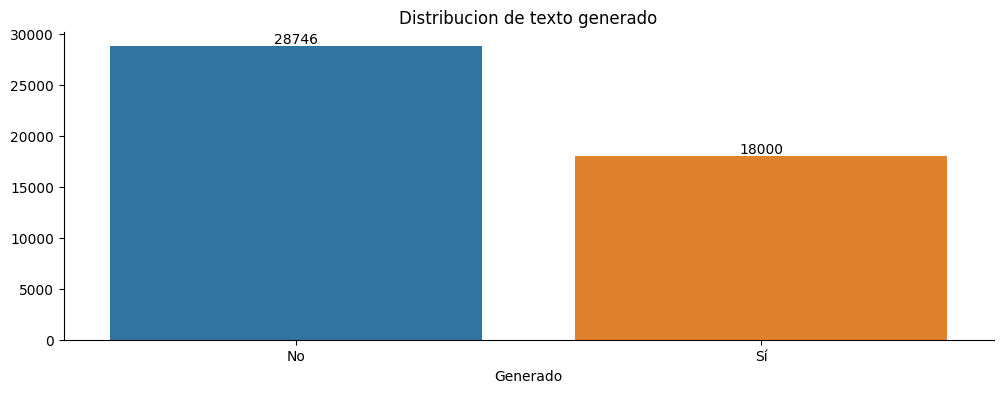

In [7]:
# Visualización de la proporción de los nuevos datos
plot_text_distribution(dataframe_train_amp)

## Procesado de datos para el modelo

In [8]:
# Escogiendo las columnas relevantes para el modelo
data_train = dataframe_train_amp[['text', 'generated']]
data_test  = dataframe_test[['text']]

Debido a que se va a hacer uso de un modelo de lenguaje natural (Específicamente, BERT), tiene una limitación en la cantidad de palabras a procesar, se analizó la cantidad de textos que no cumple la capacidad que tiene el modelo escogido

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0.98, 'Distribucion de la longitud del texto')

<Figure size 4000x5000 with 0 Axes>

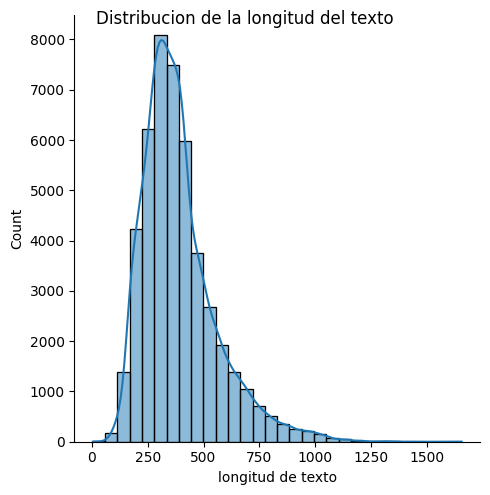

In [9]:
# Viendo la longitud de cada uno de los textos
lengths = data_train[['text']].map(lambda x: len(x.split()))
lengths.rename(columns = {'text': 'longitud de texto'}, inplace = True)

# Visualización la distribución de esas longitudes
fig = plt.figure(figsize = (40, 50))
plot = sns.displot(data = lengths, x = 'longitud de texto', bins = 30, kde = True)
plot.fig.suptitle('Distribucion de la longitud del texto')

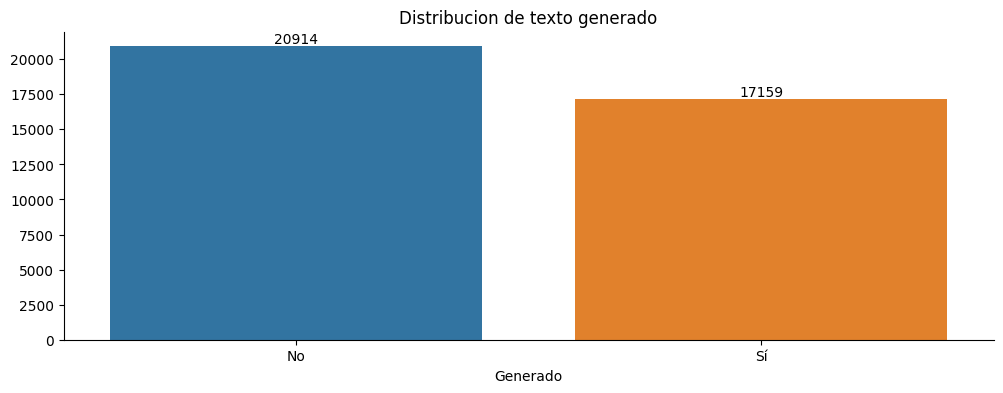

In [10]:
# Tomando los datos que cumplen la longitud adecuada
data = data_train[lengths['longitud de texto'] <= 512]
data.reset_index(drop = True, inplace = True)

# Viendo la nueva distribución de datos
plot_text_distribution(data)

## Entrenamiento del modelo

In [11]:
# Separando los datos en entrenamiento y testeo para entrenar el modelo
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, :-1],
                                                    data.iloc[:, -1],
                                                    test_size = 0.2)

Finalmente, dado que ya existen modelos de BERT entrenados, se opta por usar estos y solamente entrenar una última capa para dar la clasificación buscada. En esto, se notó que el modelo mejoraba en cada etapa, pero había un empeoramiento en el transcurso de cada una a partir de cierto punto, por eso se decidió hacer un cambio de la tasa de aprendizaje a partir de la tercera y última etapa.

In [12]:
# Creando el callback
callback = keras.callbacks.LearningRateScheduler(scheduler)

# Invocando el modelo ya entranado de BERT
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    'distil_bert_base_en_uncased',
    sequence_length = 512)
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    'distil_bert_base_en_uncased',
    num_classes  = 1,
    activation   = keras.activations.sigmoid,
    preprocessor = preprocessor)

# Haciendo que solo se entrene la parte necesaria
classifier.backbone.trainable = False

# Especificando cómo entrenar el modelo
classifier.compile(loss = ['binary_crossentropy'],
                   optimizer = keras.optimizers.Adam(1e-4),
                   metrics = ['accuracy', 'AUC'])

In [13]:
# Entrenando el modelo
classifier.fit(x = x_train['text'].to_list(), y = y_train,
               batch_size = 8, epochs = 3,
               validation_data = (x_test['text'].to_list(), y_test),
               callbacks = [callback])

Epoch 1/3


I0000 00:00:1727451603.590306      72 service.cc:145] XLA service 0x7eca54004b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727451603.590377      72 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   2/3808 ━━━━━━━━━━━━━━━━━━━━ 5:14 83ms/step - AUC: 0.1208 - accuracy: 0.4688 - loss: 0.7047       

I0000 00:00:1727451636.296864      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3808/3808 ━━━━━━━━━━━━━━━━━━━━ 422s 100ms/step - AUC: 0.9774 - accuracy: 0.9315 - loss: 0.1999 - val_AUC: 0.9970 - val_accuracy: 0.9358 - val_loss: 0.1560 - learning_rate: 1.0000e-04
Epoch 2/3
3808/3808 ━━━━━━━━━━━━━━━━━━━━ 344s 90ms/step - AUC: 0.9960 - accuracy: 0.9774 - loss: 0.0688 - val_AUC: 0.9971 - val_accuracy: 0.9347 - val_loss: 0.1649 - learning_rate: 1.0000e-04
Epoch 3/3
3808/3808 ━━━━━━━━━━━━━━━━━━━━ 345s 90ms/step - AUC: 0.9965 - accuracy: 0.9811 - loss: 0.0602 - val_AUC: 0.9975 - val_accuracy: 0.9489 - val_loss: 0.1337 - learning_rate: 1.0000e-04


In [14]:
classifier.summary()

Preprocessor: "distil_bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 1)                 │             769 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 68,136,965 (259.92 MB)

 Trainable params: 591,361 (2.26 MB)

 Non-trainable params: 66,362,880 (253.15 MB)

 Optimizer params: 1,182,724 (4.51 MB)

In [15]:
# Guardando el modelo obtenido
classifier.save('/kaggle/working/Modelo1.keras')

In [16]:
real_essay = "Luke had no idea that his life would change so soon after his high school graduation. He was working two part-time jobs in agrocey store and a bank when his friend Don invited him to go to Europe on a cattle boat. Luke couldn\'t say no.\n\nIn 1945, World War 2 was over in Europe,and manu countries were left ruins. To help these countries recover their food and supplies,animals, and more, 44 nations joined together to help the nation they are called the Seagoing Cowboys to take care of the horses, young cows, and mules that were shiped overseas.\n\nBy the time he was discharged in 1947,Luke had made nine trips-the most of any Seagoing Cowboy. I had the side benifit of seeing Europe and China. But seeing the Acroplis in Greece was special,he says. So taking a gondola ride in Venice,Italy,a city with streets of water. A cargo of 335 horses plus enough hay and oats to feed them.\n\nIt took two weeks to cross the Atlantic Ocean from the eatern coast of the United States and a month to get to china. Caring for animals during the crossings kept Luke busy. They fed the animals three times a day water,bales of hay,and bags of oats. Stalls had to be cleaned.\n\nBeing a Seagoing cow was much more than an adventure for Luke. It opened up the world to him. Im grateful for the opportunity,he says. It made him more aware of people of other countries and their needs.\n\nIn conclusion Luke had the best time of his life being a Seagoing Cowboy he didn\'t no his life would change so soon after his high school graduation. In 1945 world war 2 made places get ruined so he decied to go to Seagoing Cowboys. He help animals like horses,young cows,and mules too. He had so much to do but he did it and yes it was hard but he did what he was suppossed to do. A Seagoing Cow boy was more than an adventure for Luke. It opened the world up to him. He is gratefull of the opportunity."
gen_essay = "'I believe that dress codes are beneficial to the school environment. There are several reasons why I take this position. \n\nFirstly, dress codes help to promote a sense of equality and fairness among students. When all students are required to adhere to the same dress code, it eliminates the pressure to wear expensive or trendy clothing. This means that students from different socioeconomic backgrounds are less likely to feel excluded or marginalized based on their clothing choices.\n\nSecondly, dress codes can help to reduce distractions in the classroom. When students are dressed appropriately for school, they are less likely to be preoccupied with how they look or what they are wearing. This can help them to focus on their studies and be more productive in class.\n\nLastly, dress codes can instill a sense of discipline and professionalism among students. By requiring students to dress in a particular way, it sends a message that school is a place for learning and that students should take their education seriously.\n\nFor example, when our school implemented a dress code last year, we noticed a significant improvement in the overall behavior and attitudes of our students. Fewer distractions, improved focus, and a more professional attitude created a more positive learning environment for everyone.\n\nIn conclusion, while some students may not like the idea of a dress code, I believe that the benefits far outweigh any potential drawbacks. By promoting equality, reducing distractions, and instilling discipline, dress codes can be an effective tool for creating a positive learning environment in schools.'"
preds = classifier.predict([real_essay, gen_essay])
print("Probabilidad de que el primer ensayo sea generado: ", preds[0])
print("Probabilidad de que el segundo ensayo sea generado: ", preds[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Probabilidad de que el primer ensayo sea generado:  [0.00239082]
Probabilidad de que el segundo ensayo sea generado:  [0.9999999]


In [17]:
classifier.predict(["Im an artificial intelligence"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.18734224]], dtype=float32)

## Conclusiones
1. Como el modelo está entrenado solo en ensayos estudiantiles, podría generar sesgos al asumir que ciertos patrones de escritura son propios de los estudiantes, mientras que otros podrían ser considerados automáticamente generados por IA. Esto podría afectar a estudiantes que tienen estilos de escritura no convencionales o que utilizan herramientas asistidas por IA para mejorar su trabajo.
2. El problema de clasificar si un texto fue generado sigue siendo un problema abierto muy dificil, con el crecimiento de los LLMs y la cantidad de textos disponibles creciendo cada vez mas y mas, los textos generados son cada vez mas humanos que los anteriores y este problema se hace mas dificil de generalizar.

En resumen, aunque el modelo podría ser útil para ciertos fines académicos, las limitaciones en su capacidad para generalizar y las posibles implicaciones éticas de su uso deben abordarse cuidadosamente antes de implementarlo en entornos educativos o en otros contextos.

## Implicaciones Eticas
1. A pesar de la alta precisión, ningún modelo es infalible. Siempre existe un margen de error que podría llevar a falsas acusaciones de trampas o fraude académico, lo que afectaría la reputación y carrera de los estudiantes. Es fundamental garantizar que el uso de esta tecnología no cause sanciones injustas, y que siempre haya un proceso de apelación o verificación adicional por parte de los educadores.
2. Existe el riesgo de que los educadores se vuelvan demasiado dependientes de estos modelos, lo que podría reducir su papel en la evaluación crítica de los trabajos escritos. Además, podría desincentivar el diálogo y el aprendizaje sobre el uso responsable de tecnologías generativas. En lugar de simplemente confiar en el modelo, es necesario fomentar un enfoque educativo equilibrado que incluya discusiones sobre ética y creatividad en la era de la IA.

## Trabajo futuro
A partir de esta base algo que se podria hacer es ampliar el modelo hacia mas contextos para que a la hora de usarlo se pueda tambien especificar un tema y el modelo pueda ser mas preciso